# GPU implementation of Bfastmonitor using Python
The bfast package provides a highly-efficient parallel implementation for the Breaks For Additive Season and Trend (BFASTmonitor) proposed by Verbesselt et al. The implementation is based on OpenCL.

## This code runs bfastmonitor over an entire time series folder

The script below runs bfastmonitor over the timeseries data downloaded in SEPAL in blocks, and patches together tiles to export mean magnitudes and breaks as geotiffs, pngs, and .npy files. The output is also displayed in a digital map. Make sure to run through the cells sequentially.

* First download data using the SEPAL time series downloader (not in this script). The downloads will be saved in your downloads folder and look like: /home/'username'/downloads/Time_series_2020-09-01_16-22-26/0|1|2|3

* Import packages

* Select data

* Set parameters

* Select monitoring period

* Run bfastmonitor and save intermediate output

* Load output

* Merge and save output

* Display output




In [1]:
import os
from os.path import expanduser

import wget
import numpy as np
from datetime import datetime
import copy
import matplotlib
import matplotlib.pyplot as plt
import subprocess

import json

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal, gdal_array, osr

import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import Layout
from ipyfilechooser import FileChooser
import folium

from PIL import Image
from matplotlib import cm

# import functions from functions.py
from functions import set_base_output_dir, set_output_dir, get_data_dict, merge_tiles, set_paths, _find_index_date, normalize, select_negatives, get_julian_dates
from plotting_funcs import save_plot, merge_plots, classify_output, plot_output_matplotlib, set_corners, export_GTiff, classify_magnitudes, merge_plots2

# Import the Timeseries class from time_series.py
from time_series import Timeseries
print(Timeseries.__doc__)

# Import widgets for GUI parameter selection
from widgets import get_widgets, get_dates_widgets
output_directory_chooser, k_chooser,freq_chooser,trend_chooser,hfrac_chooser,level_chooser,backend_chooser, load_chooser, block_size_chooser, plot_display_data_chooser = get_widgets()


    The timeseries class is a wrapper for using SEPAL timeseries data with bfast. 
    It wraps together a data tile with associated dates file and metadata. 
    It also allows for saving and loading the output rasters in a specified directory. 
    


In [2]:
%matplotlib inline

In [3]:
display(output_directory_chooser)

interactive(children=(Text(value='', description='Output storage name: (country/location name, e.g. "Guyana")'…

In [4]:
base_output_dir = set_base_output_dir(output_directory_chooser)

Defaulting to output directory name: stored_time_series/output


# Select your timeseries folder

In [5]:
path = expanduser("~")
file_chooser = FileChooser(path)
display(file_chooser)

FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

In [6]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)

/home/dven/downloads/Time_series_2020-09-09_13-02-40_Australia_small/


## Select the directories you are interested in

In [7]:
items = [widgets.Checkbox(value = True,description = i) for i in os.listdir(timeseries_directory)]
widgets.VBox(items)

In [8]:
# set path to dates file and create Timeseries objects of tiles
load_list=[]
for xi in items:
    if xi.value == True:
        load_list.append(xi.description)

run_dict = {}
for directory in load_list:
    
    segment_location = timeseries_directory + directory + "/"
    data_list = set_paths(timeseries_directory = segment_location)
    run_dict[directory] = data_list
    
    for tile in data_list:
        print(tile)

Data consists of tiles, setting up tiles in 'data_list' 
Timeseries class holding 956 dates, sized 755 by 599.


In [9]:
# Choose parameters
display(k_chooser)
display(freq_chooser)
display(trend_chooser)
display(hfrac_chooser)
display(level_chooser)
display(backend_chooser)

interactive(children=(Dropdown(description='k, harmonic terms', index=2, layout=Layout(height='auto', width='5…

interactive(children=(IntSlider(value=365, description='freq, frequency of seasonal model (days)', layout=Layo…

interactive(children=(Checkbox(value=False, description='add trend', layout=Layout(height='auto', width='500px…

interactive(children=(FloatSlider(value=0.25, description='Bandwith relative to sample size', layout=Layout(he…

interactive(children=(SelectionSlider(description='Significance level of the monitoring', layout=Layout(height…

interactive(children=(Dropdown(description='backend', layout=Layout(height='auto', width='500px'), options=('o…

In [10]:
# Set parameters
k = k_chooser.result
freq = freq_chooser.result
trend = trend_chooser.result
hfrac = hfrac_chooser.result
level = 1 - level_chooser.result
backend = backend_chooser.result
verbose = 1
device_id = 0

In [11]:
dates = data_list[0].dates
start_date = dates[0] # 0 or 10 does not work.. 100 did ########
end_date = dates[-1]
pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)

monitoring_period_chooser, history_period_chooser = get_dates_widgets(options = options, index = index)

display(monitoring_period_chooser)
display(history_period_chooser)

interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 7544), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2000-01-01', Timestamp('…

In [12]:
start_monitor, end_monitor = monitoring_period_chooser.result
start_hist = history_period_chooser.result

if history_period_chooser.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

if start_monitor < dates[50]:
    raise Warning("Your history period is relatively short, did you move the monitoring date range to a later date?")

In [13]:
display(block_size_chooser)

interactive(children=(Dropdown(description='block size, bigger is generally faster, but may result in memory i…

In [14]:
x_block = y_block = block_size_chooser.result


for data_list in run_dict:
    # loading bar
    with tqdm(total=len(run_dict)) as pbar1:
        
        
        save_location = base_output_dir + "/" + data_list
        if not os.path.exists(save_location):
            os.makedirs(save_location)
        

        # loop over tile(s) in the data_list
        for counter, tile in enumerate(run_dict[data_list]):
            pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(run_dict[data_list])) )

            tile.set_bfast_parameters(start_monitor = start_monitor, 
                                         end_monitor = end_monitor,
                                         start_hist = start_hist,
                                         freq = freq,
                                         k = k,
                                         hfrac = hfrac,
                                         trend = trend,
                                         level = level,
                                         backend=backend,
                                         verbose=verbose,
                                         device_id=device_id)

            tile.get_bfast_parameters()

            tile.loop_blocks(x_block_size = x_block,
                                y_block_size = y_block)

            tile.log_all_output(output_dir_name=save_location)

            run_dict[data_list][counter] = '0'
            del(tile)

            pbar1.update(1)

    pbar1.close()


Processing blocks of tile::   0%|          | 0/2 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x3616e00>]
Monitoring starts at:  2013-01-15 00:00:00
Monitoring ends at:  2020-08-27 00:00:00
Dataset history starts at:  2000-01-01 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  755 599
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2013-01-15 00:00:00
end monitor:  2020-08-27 00:00:00
start history:  2000-01-01 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile:: 100%|██████████| 2/2 [00:14<00:00,  7.49s/it]

--- runtime for kernel execution:		0.18042635917663574
--- runtime for data transfer (device->host):	0.026218175888061523
512 0 243 512


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile:: : 3it [00:23,  7.70s/it]                     

--- runtime for data initialization:		0.0026199817657470703
--- runtime for data transfer (host->device):	0.0502009391784668
--- runtime for data preprocessing:		0.007128477096557617
--- runtime for kernel execution:		0.06342101097106934
--- runtime for data transfer (device->host):	0.008171796798706055
0 512 512 87



Processing blocks of tile:: : 4it [00:28,  6.90s/it]

--- runtime for data initialization:		0.002602100372314453
--- runtime for data transfer (host->device):	0.018253087997436523
--- runtime for data preprocessing:		0.004976511001586914
--- runtime for kernel execution:		0.0357358455657959
--- runtime for data transfer (device->host):	0.005308866500854492
512 512 243 87


Processing blocks of tile:: : 4it [00:32,  8.01s/it]

--- runtime for data initialization:		0.0026378631591796875
--- runtime for data transfer (host->device):	0.008899211883544922
--- runtime for data preprocessing:		0.003342866897583008
--- runtime for kernel execution:		0.01790165901184082
--- runtime for data transfer (device->host):	0.0025551319122314453
Fitting model over all blocks took 32.03489637374878 seconds.



Processing tile 1 out of 1: 100%|██████████| 1/1 [00:32<00:00, 32.30s/it]


In [15]:
run_dict = {}
for directory in load_list:
    
    segment_location = timeseries_directory + directory + "/"
    dates_location =  timeseries_directory + directory + "/dates.csv"
    
    data_list = set_paths(timeseries_directory = segment_location)
    
    run_dict[directory] = data_list
    
    for tile in data_list:
        #print(tile)
        
        tile.start_monitor, tile.end_monitor = monitoring_period_chooser.result
        tile.start_hist = history_period_chooser.result
        
        tile.crop_dates(tile.dates)
        tile.load_breaks_means_arrays_from_file(output_dir_name = base_output_dir + "/" +  directory)

Data consists of tiles, setting up tiles in 'data_list' 


percentage breaks found 66.86729538192793
percentage cells lacking data to find results found 0.0
png saved in stored_time_series/output/0/pngs/magnitudes_0.png
colorbar saved in stored_time_series/output/0/colorbars/colorbar_magnitudes_0.png
Geotiff saved in stored_time_series/output/0/geotifs/magnitudes_0.tif
Geotiff saved in stored_time_series/output/0/geotifs/breaks_indexed_0.tif
mean:  408.4826
stdev:  244.0908
max value:  3616.1465
min value:  -1575.3489
uint16 set
Geotiff saved in stored_time_series/output/0/geotifs/magnitudes_classified_0.tif
png saved in stored_time_series/output/0/pngs/magnitudes_negative_0.png
colorbar saved in stored_time_series/output/0/colorbars/colorbar_magnitudes_negative_0.png
Geotiff saved in stored_time_series/output/0/geotifs/magnitudes_negative_0.tif
Geotiff saved in stored_time_series/output/0/geotifs/breaks_binary_0.tif
Geotiff saved in stored_time_series/output/0/geotifs/breaks_binary_negative_0.tif
Geotiff saved in stored_time_series/output/0/g

/home/dven/bfastmonitor_cpu/dven/plotting_funcs.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)


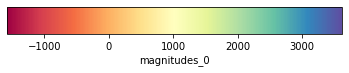

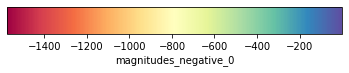

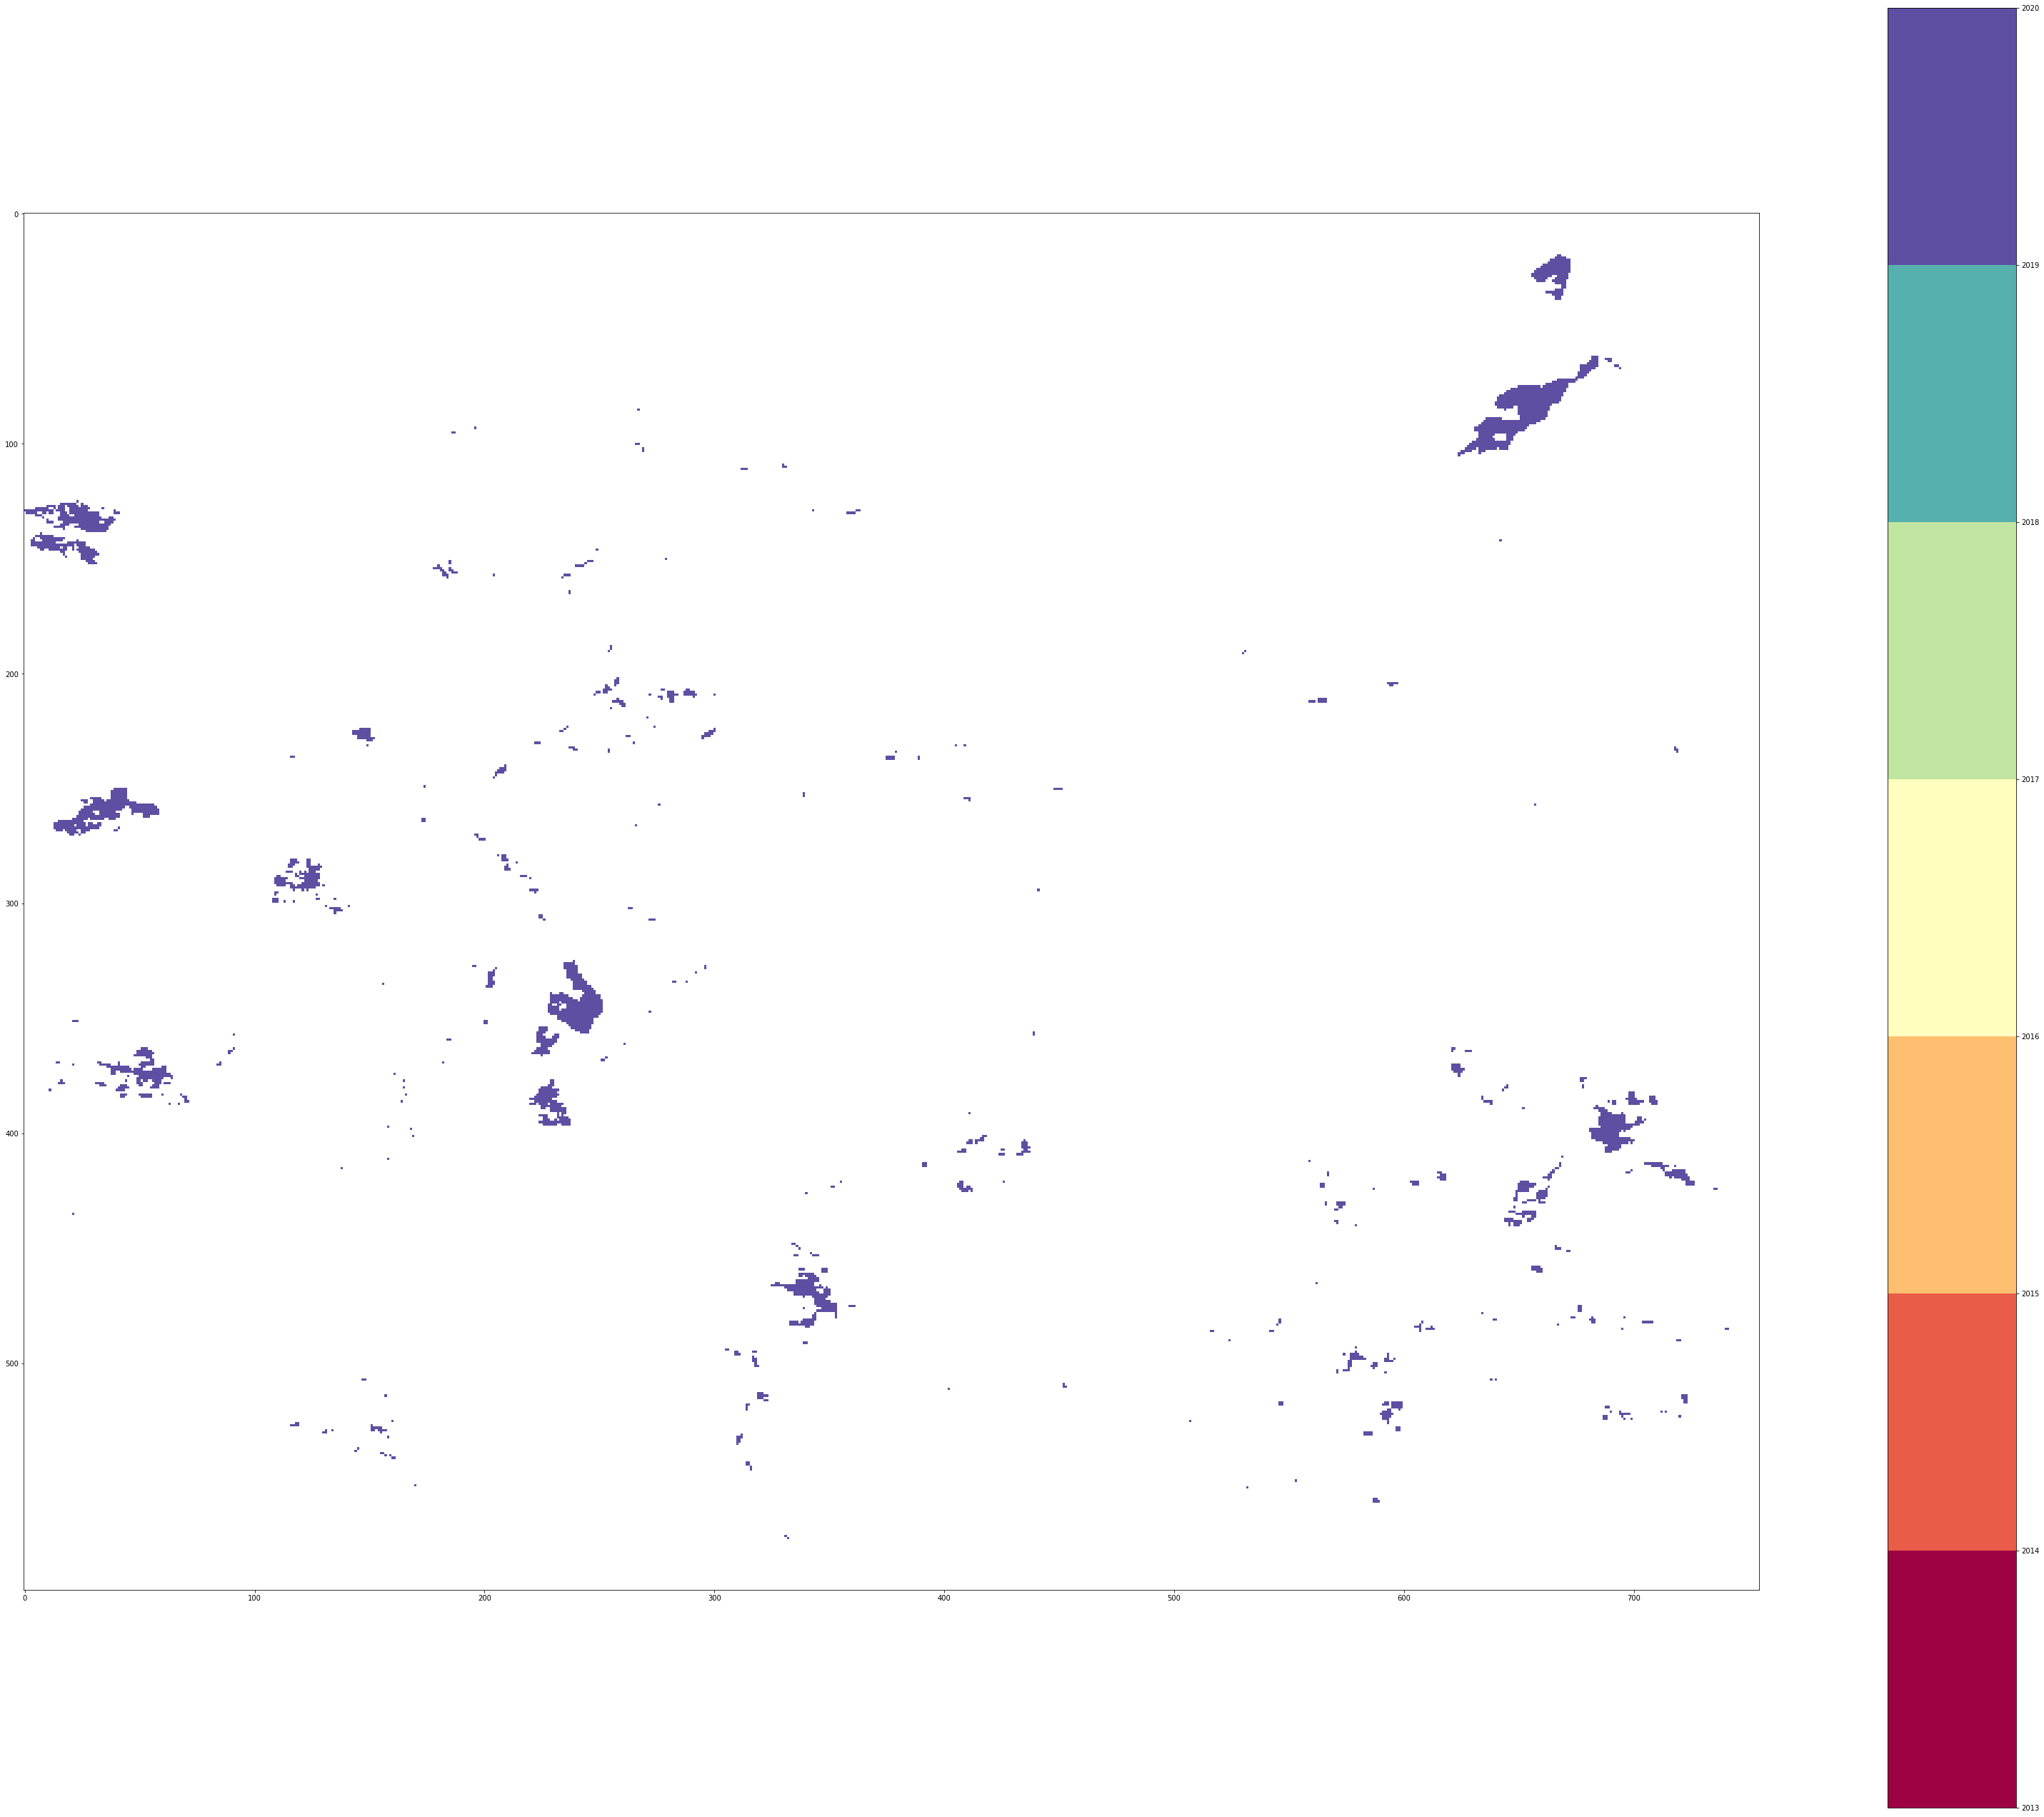

min_lat  -37.50852586771174
max_lat  -37.50852586771174
min_lon  149.0822485957939
max_lon  149.0822485957939
saved in stored_time_series/output/0/corners.json


In [16]:
for data_list in run_dict:
    save_location = base_output_dir + "/" + data_list
    tiles_data = run_dict[data_list]
    
    perc_lacking_data_sum, perc_breaks_sum= 0,0
    for tile in tiles_data:
        minus2count,minus1count,perc_lacking_data,perc_breaks = tile.check_arrays()
        perc_breaks_sum += perc_breaks
        perc_lacking_data_sum+= perc_lacking_data
        
    print("percentage breaks found", perc_breaks_sum/len(tiles_data))
    print("percentage cells lacking data to find results found", perc_lacking_data_sum/len(tiles_data))
    
    if len(tiles_data) > 1:
        means_orig, breaks_orig = merge_tiles(tiles_data,output_dir_name = save_location)
    else:
        means_orig = tiles_data[0].means_array
        breaks_orig = tiles_data[0].breaks_array
    
    save_plot(means_orig, save_location, save_name = "magnitudes_" + data_list)
    export_GTiff(tiles_data, output_dir = save_location, array = means_orig, output_name = "magnitudes_" + data_list + ".tif")
    export_GTiff(tiles_data, output_dir = save_location, array = breaks_orig, output_name = "breaks_indexed_" + data_list + ".tif")

    classified_means = classify_magnitudes(means_orig)
    classified_means = np.nan_to_num(classified_means,nan=0).astype("uint16")
    export_GTiff(tiles_data, output_dir = save_location, array = classified_means, output_name = "magnitudes_classified_" + data_list + ".tif")
    
    # add colors to classified raster
    func = "oft-addpct.py"
    clas_tif = save_location + "/geotifs/magnitudes_classified_" + data_list + ".tif"
    clas_tif_result = save_location + "/geotifs/magnitudes_classified_" + data_list + "_result.tif"
    color_table = "color_table.txt"
    
    ps = subprocess.Popen(('echo', color_table), stdout=subprocess.PIPE)
    output = subprocess.check_output((func, clas_tif, clas_tif_result), stdin=ps.stdout)
    ps.wait()
    
    # select only negative magnitudes
    means_neg, breaks_indexed, breaks_indexed_neg, binary_breaks, negative_binary_breaks = select_negatives(means_orig, breaks_orig)
    save_plot(means_neg, output_dir = save_location, save_name = "magnitudes_negative_" + data_list)

    # save negative means and breaks
    export_GTiff(tiles_data, output_dir = save_location, array = means_neg ,output_name = "magnitudes_negative_" + data_list + ".tif")
    export_GTiff(tiles_data, output_dir = save_location, array = binary_breaks ,output_name = "breaks_binary_" + data_list + ".tif")
    export_GTiff(tiles_data, output_dir = save_location, array = negative_binary_breaks ,output_name = "breaks_binary_negative_" + data_list + ".tif")

    dates_monitor = []
    dates = tiles_data[0].cropped_dates

    # collect dates for monitor period
    for i in range(len(dates)):
        if start_monitor <= dates[i]:
            dates_monitor.append(dates[i])
    dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period
    
    # julian_date output
    julian_breaks, year_breaks = get_julian_dates(dates_array,breaks_indexed)
    negative_julian_breaks, negative_year_breaks = get_julian_dates(dates_array,breaks_indexed_neg)

    # save negative means and breaks
    export_GTiff(tiles_data, output_dir = save_location, array = julian_breaks ,output_name = "breaks_julian_" + data_list + ".tif")
    export_GTiff(tiles_data, output_dir = save_location, array = negative_julian_breaks ,output_name = "breaks_julian_negative_" + data_list + ".tif")

    export_GTiff(tiles_data, output_dir = save_location, array = year_breaks, output_name = "breaks_year_" + data_list + ".tif")
    export_GTiff(tiles_data, output_dir = save_location, array = negative_year_breaks, output_name = "breaks_year_negative_" + data_list + ".tif")
    
    # matplotlib
    breaks_years_neg, idx_starts, ticklist = classify_output(start_monitor,end_monitor,breaks_indexed_neg,dates_array)
    plot_output_matplotlib(idx_starts,breaks_years_neg,ticklist)

    # for plotting folium map
    set_corners(save_location, tiles_data)
    
    


In [17]:
display(plot_display_data_chooser)

interactive(children=(Dropdown(description='data to plot', layout=Layout(height='auto', width='500px'), option…

In [18]:
if not plot_display_data_chooser.result:
    print("make sure to run the block above")

m = merge_plots2(data_list = run_dict[data_list], base_output_dir=base_output_dir,plot_name= plot_display_data_chooser.result)
m.save(base_output_dir + "/" +"0/" + plot_display_data_chooser.result + ".html")
m

0
stored_time_series/output/0/pngs/magnitudes_0.png
